In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.insert(0,"/analysis/fabiane/phd/nitorch/")
sys.path.insert(0,"/analysis/fabiane/phd/patch_individual_filters/")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import h5py
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from nitorch.data import load_nifti
from nitorch.transforms import  ToTensor
from pif import PatchIndividualFilters3D

/home/fabiane/anaconda2/envs/mort1/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Parameters

In [5]:
gpu = 1
model_dir = "/analysis/ritter/projects/Methods/Eitel_local_filter/experiments_submission/models/ADNI/full_set/baseline/"
model_path = os.path.join(model_dir,"repeat_0_cv_fold_0_BEST_ITERATION.h5")

### Model definition

In [6]:
class SixtyFourNet(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SixtyFourNet, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

        self.pif = PatchIndividualFilters3D([10,13,10],
                                            filter_shape=(3,3,3),
                                            patch_shape=(5,5,5),
                                            num_local_filter_in=64,
                                            num_local_filter_out=3,
                                            overlap=1,
                                            reassemble=False,
                                            debug=False)

        # 4, 64, 1, 2, 1
        self.classifier_scratch = nn.Sequential(
            nn.Linear(1134, 100),
            nn.Linear(100, 1)
        )

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        x = F.elu(self.pif(x))
        x = self.flatten(x)
        x = self.classifier_scratch(x)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [7]:
# load pre-trained weights
net = SixtyFourNet()
net.load_state_dict(torch.load(model_path))
net = net.cuda(gpu)
net.eval()

SixtyFourNet(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (pif): PatchIndividualFilters3D(
    (conv_0): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_1): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_2): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_3): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_4): Conv3d(64, 3, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (conv_5): Conv3d(64, 3, kernel_size=(3, 3, 

In [8]:
neuron = list(dict(net.named_children())["Conv_1"].parameters())[0][0]

# Generate feature visualization through optimization

### Create starting point

In [9]:
base = torch.rand((1, 96, 114, 96))

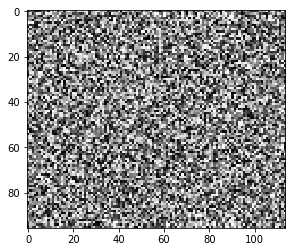

In [10]:
plt.imshow(base[0,:,:,48], cmap='gray')

In [11]:
start, end = 32, 32+5

In [12]:
val_h5 = h5py.File("/analysis/ritter/data/ADNI_HDF5/Splits_Eitel/val_AD_CN_2Yr15T_plus_UniqueScreening_quickprep_(96, 114, 96)_reducedValSize.h5", 'r')
X, y = val_h5['X'][start:end], val_h5['y'][start:end]
del val_h5

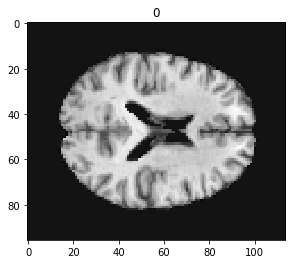

In [13]:
plt.imshow(X[0,:,:,48], cmap='gray')
plt.title(y[0])
plt.show()

In [14]:
for i, img in enumerate(X):
    X[i] = img / np.max(img) # normalize
X = torch.Tensor(X)

In [15]:
n_filters = 5

In [16]:
activation = None
class SaveActivation():
    def __init__(self, n_filters):
        self.activation = []
        self.n_filters = n_filters

    def __call__(self, module, input, output):
        print(output.data.shape)
        print(len(output.data) * self.n_filters)
        for i in range(len(output.data)):
            for j in range(self.n_filters):
                self.activation.append(output.data[i, j])
        
    def get_activation(self):
        return self.activation

In [17]:
saver = SaveActivation(n_filters)
len(saver.get_activation())

0

In [18]:
hook = net.Conv_4.register_forward_hook(saver)

In [19]:
net.forward(torch.unsqueeze(X, 1).cuda(gpu))

torch.Size([5, 64, 10, 13, 10])
25


tensor([[-2.9323],
        [-2.4582],
        [ 1.4679],
        [10.0026],
        [ 9.6362]], device='cuda:2', grad_fn=<AddmmBackward>)

In [20]:
len(saver.get_activation())

25

In [21]:
saver.n_filters

5

In [22]:
activation_shape = saver.get_activation()[0].shape
n_imgs = len(X)

activations = np.zeros(shape=(n_filters, )+tuple(activation_shape))
print(np.shape(activations))

for i in range(n_imgs):
    print("Next")
    for j in range(n_filters):
        activation = saver.get_activation()[(i*n_filters)+j].cpu().numpy()
        #plt.imshow(activation[:,:,5], cmap='gray')  
        #plt.show()
        activations[j] += activation

(5, 10, 13, 10)
Next
Next
Next
Next
Next


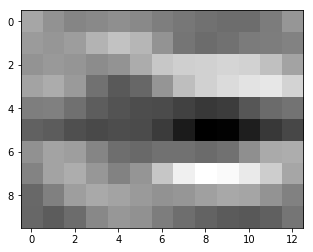

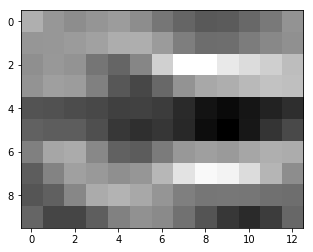

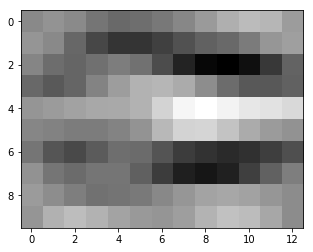

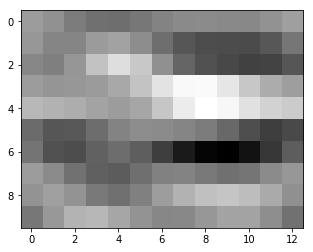

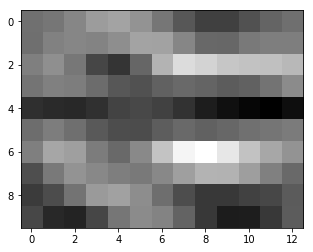

In [23]:
for activation in activations:
    plt.imshow(activation[:,:,5]/n_filters, cmap='gray')
    plt.show()

Backpropagate from feature map

In [24]:
# Create a model up to the feature map intended for investigation
class SubModel(nn.Module):
    def __init__(self, drp_rate=0.3):
        super(SubModel, self).__init__()
        self.drp_rate = drp_rate
        self.drop = nn.Dropout3d(p=self.drp_rate)
        self.Conv_1 = nn.Conv3d(1, 64, kernel_size=3, stride=1, padding=0)
        self.pool_1 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)
        self.Conv_2 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_2 = nn.MaxPool3d(kernel_size=3, stride=2, padding=0)
        self.Conv_3 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.Conv_4 = nn.Conv3d(64, 64, kernel_size=3, stride=1, padding=0)
        self.pool_4 = nn.MaxPool3d(kernel_size=3, stride=3, padding=0)

    def encode(self, x, print_size=False):
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_1(x))
        h = self.drop(self.pool_1(x))
        x = F.elu(self.Conv_2(h))
        if print_size:
            print(x.shape)
        h = self.drop(self.pool_2(x))
        x = F.elu(self.Conv_3(h))
        if print_size:
            print(x.shape)
        x = F.elu(self.Conv_4(x))
        #x = self.Conv_4(x) # remove activation to match original feature map
        if print_size:
            print(x.shape)
        return x

    def forward(self, x):
        print_size = False
        x = self.encode(x, print_size=print_size)
        return x
    
    def flatten(self, x):
        return x.view(x.size(0), -1)

In [25]:
sub_model = SubModel()

In [26]:
sub_model.state_dict().keys()

odict_keys(['Conv_1.weight', 'Conv_1.bias', 'Conv_2.weight', 'Conv_2.bias', 'Conv_3.weight', 'Conv_3.bias', 'Conv_4.weight', 'Conv_4.bias'])

In [27]:
new_state_dict = sub_model.state_dict()
old_state_dict = net.state_dict()
for name, param in old_state_dict.items():
    if name in new_state_dict.keys():
        print(name)
        new_state_dict[name].copy_(param)

Conv_1.weight
Conv_1.bias
Conv_2.weight
Conv_2.bias
Conv_3.weight
Conv_3.bias
Conv_4.weight
Conv_4.bias


In [28]:
sub_model.load_state_dict(new_state_dict)

In [29]:
sub_model.cuda(gpu)
sub_model.eval()

SubModel(
  (drop): Dropout3d(p=0.3)
  (Conv_1): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_1): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (Conv_2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_2): MaxPool3d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv_3): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (Conv_4): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1))
  (pool_4): MaxPool3d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
)

In [30]:
X = X.requires_grad_()

In [31]:
sub_model.zero_grad()

In [32]:
res = sub_model.forward(torch.unsqueeze(X, 1).cuda(gpu))

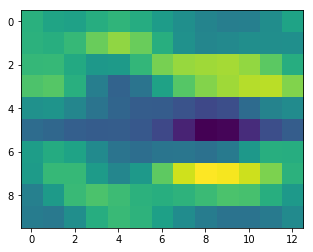

In [33]:
plt.imshow(saver.get_activation()[5].cpu().numpy()[:,:,5])
plt.show()

In [34]:
res_img = res[1].cpu().detach().numpy()

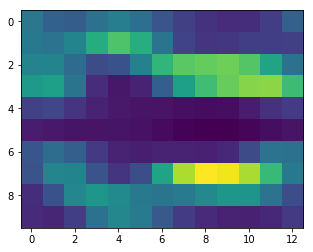

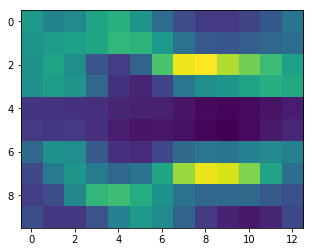

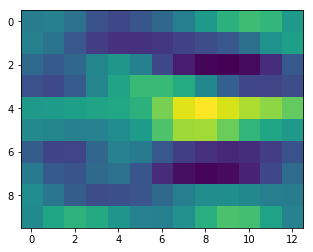

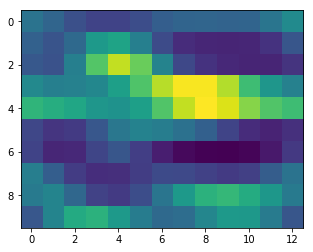

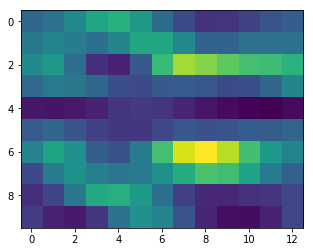

In [35]:
for filter_pos in range(5):
    plt.imshow(res_img[filter_pos][:,:,5])
    plt.show()

In [36]:
res.shape

torch.Size([5, 64, 10, 13, 10])

In [37]:
image_pos = 1
filter_pos = 20

In [38]:
grad = torch.mean(torch.abs(res[image_pos, filter_pos]))

In [39]:
grad.backward()

In [40]:
print(torch.sum(X.grad))

tensor(-0.1375)


In [41]:
print(torch.sum(X.grad))

tensor(-0.1375)


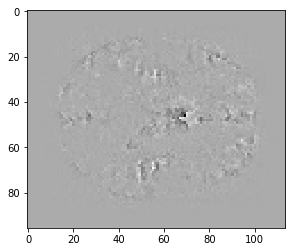

In [42]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

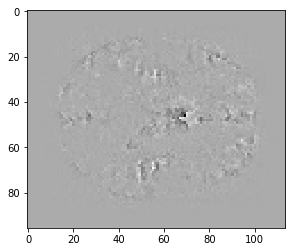

In [43]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

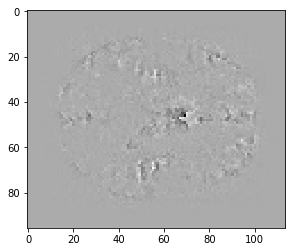

In [44]:
#for i in range(5):
plt.imshow(X.grad.cpu().numpy()[1,:,:,48], cmap='gray')
plt.show()

### Optimization loop

In [45]:
torch.FloatTensor([[[0.006, 0.061, 0.242, 0.383, 0.242, 0.061, 0.006]]])

tensor([[[0.0060, 0.0610, 0.2420, 0.3830, 0.2420, 0.0610, 0.0060]]])

In [47]:
std = torch.Tensor([0.05, 0.05, 0.05]).repeat(3,3,1).unsqueeze(0)

In [48]:
gaussian_kernel = torch.normal(mean=1, std=std).unsqueeze(0)

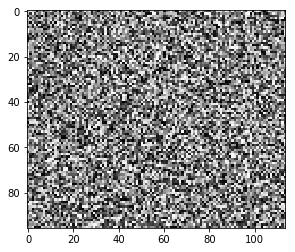

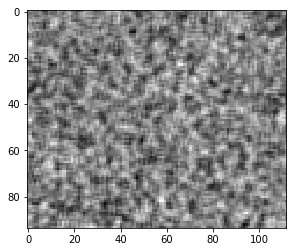

In [50]:
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

smoothed = F.conv3d(base, weight=gaussian_kernel, stride=1)
plt.imshow(smoothed.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

In [51]:
base.shape

torch.Size([1, 1, 96, 114, 96])

In [52]:
gaussian_kernel.shape

torch.Size([1, 1, 3, 3, 3])

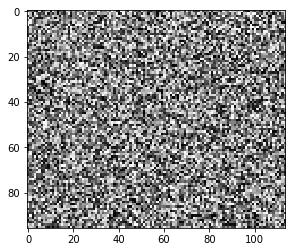

Iteration 0. Loss 0
Iteration 200. Loss -1298.9609375
Iteration 400. Loss -1299.0
Iteration 600. Loss -1299.0
Iteration 800. Loss -1299.0
Iteration 1000. Loss -1299.0
Iteration 1200. Loss -1299.0
Iteration 1400. Loss -1299.0
Iteration 1600. Loss -1299.0
Iteration 1800. Loss -1299.0


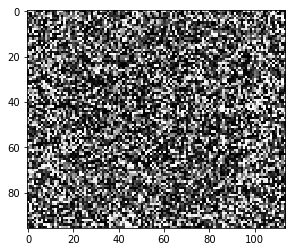

In [92]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.005)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos])) + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

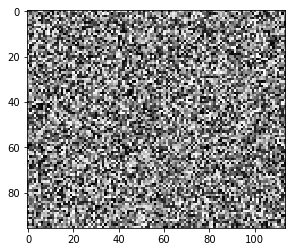

Iteration 0. Loss 0
Iteration 200. Loss -1299.7867431640625
Iteration 400. Loss -1299.9794921875
Iteration 600. Loss -1300.0
Iteration 800. Loss -1300.0
Iteration 1000. Loss -1300.0
Iteration 1200. Loss -1300.0
Iteration 1400. Loss -1300.0
Iteration 1600. Loss -1300.0
Iteration 1800. Loss -1300.0


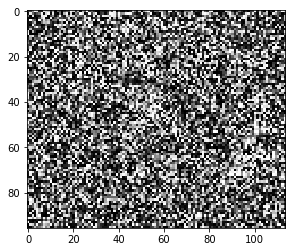

In [95]:
num_iters = 2000
base = torch.rand((1, 1, 96, 114, 96), requires_grad=True)
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()
optimizer = optim.Adam([base], lr=0.05, weight_decay=0.05)
l1_loss = nn.L1Loss(reduction='mean')
loss = 0

for i in range(num_iters+1):
    if i % 200 == 0:
        print("Iteration {}. Loss {}".format(i, loss))
    #base = F.conv3d(base, weight=gaussian_kernel, stride=1)
    sub_model.zero_grad()
    
    res = sub_model.forward(base.cuda(gpu))
    l1 = l1_loss(res[0, filter_pos], torch.zeros_like(res[0, filter_pos]))
    #print(l1)
    loss = -torch.sum(torch.abs(res[0, filter_pos]))# + l1 * 100
    #print(loss)
    loss.backward()
    optimizer.step()

plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()

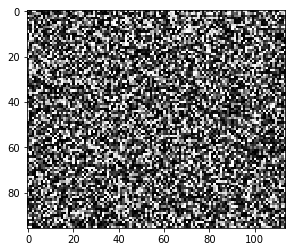

In [77]:
plt.imshow(base.cpu().detach().numpy()[0,0,:,:,48],cmap='gray')
plt.show()